In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import time
from tqdm import tqdm

    * 4082 phages + (1 hsv1 outgroup)
    * 445,098 total phage proteins (+ 53 HSV1 proteins)

In [2]:
genome_metadata = pd.read_csv('../data/genome_ncbi_metadata_with_taxonomy.csv')

In [3]:
ictv_metadata = pd.read_csv('../data/4083_ICTV_metadata.csv')

In [4]:
metadata = pd.read_csv('../data/protein_metadata.csv')

In [5]:
metadata["genome_accn"] = metadata["genome_accn"].str.replace(r"\.\d+$", "", regex=True)
metadata["genome_accn"] = metadata["genome_accn"].str.strip()

In [6]:
##################################################
#    Foldseek optimal easy-cluster output        #
##################################################

clu = pd.read_csv('../data/foldseek_easy_cluster/test_thresholds/cov5_c0.4_tm0.3_re1_e1e-2__cluster.tsv',sep='\t',header=None)

FileNotFoundError: [Errno 2] No such file or directory: '../data/foldseek_easy_cluster/test_thresholds/cov5_c0.4_tm0.3_re1_e1e-2__cluster.tsv'

In [10]:
clu.shape

(445150, 2)

# 1. Annotate clusters - link protein accessions to genome accessions and other metadata

In [11]:
def annotate_clusters(clu, protein_metadata):
    """
    Annotates protein clusters with metadata from a provided protein metadata DataFrame.

    Parameters:
    ----------
    clu : pd.DataFrame
        DataFrame containing Foldseek easy-cluster output - two columns: 'cluster' and 'members', which represent clustered 
        protein identifiers.
    
    protein_metadata : pd.DataFrame
        DataFrame containing metadata for proteins, including genome accession, phage status, 
        function, pLDDT score, PFAM annotations, and protein length.

    Returns:
    -------
    pd.DataFrame
        Annotated cluster DataFrame where each row represents a pair of cluster-member relationships, 
        enriched with metadata for both the cluster and its members.
    """
    clu.columns = ['cluster', 'members']
    clu['cluster'] = clu['cluster'].str.replace('.pdb', '', regex=True)
    clu['members'] = clu['members'].str.replace('.pdb', '', regex=True)
    
    metadata_cols = ['protein_accn', 'genome_accn', 'phage', 'function', 'pLDDT', 'PFAM1', 
                     'PFAM1_description', 'PFAM1_definition', 'protein_length']
    protein_metadata_cleaned = protein_metadata[metadata_cols].copy()

    # Merge for cluster metadata
    clu = clu.merge(protein_metadata_cleaned, left_on='cluster', right_on='protein_accn', how='left') \
        .rename(columns={'genome_accn': 'cluster_genome_accn', 'phage': 'cluster_phage',
                         'function': 'cluster_function', 'pLDDT': 'cluster_pLDDT',
                         'PFAM1': 'cluster_PFAM1', 'PFAM1_description': 'cluster_PFAM1_description',
                         'PFAM1_definition': 'cluster_PFAM1_definition','protein_length':'cluster_protein_length'}) \
        .drop(['protein_accn'], axis=1)

    # Merge for member metadata
    clu = clu.merge(protein_metadata_cleaned, left_on='members', right_on='protein_accn', how='left') \
        .rename(columns={'genome_accn': 'member_genome_accn', 'phage': 'member_phage',
                         'function': 'member_function', 'pLDDT': 'member_pLDDT',
                         'PFAM1': 'member_PFAM1', 'PFAM1_description': 'member_PFAM1_description',
                         'PFAM1_definition': 'member_PFAM1_definition','protein_length':'member_protein_length'}) \
        .drop(['protein_accn'], axis=1)

    # Remove self-matches and duplicates
    clu = clu.drop_duplicates(subset=['cluster', 'members'], keep='first')
    clu = clu[(~clu.cluster_genome_accn.isna()) | (~clu.member_genome_accn.isna())]
    clu = clu[clu.cluster != clu.members]

    # Filter out clusters with fewer than 2 members
    cluster_counts = clu.groupby('cluster')['member_genome_accn'].transform('count')
    clu = clu[cluster_counts >= 2]

    return clu

In [12]:
def group_clusters(df):
    df_grouped = df.groupby('cluster').agg({'members': 'count', 'cluster_function': 'first',\
                                           'member_PFAM1_definition':'first'})\
                            .reset_index().sort_values(by=['members'], ascending=False)\
                            .reset_index(drop=True)
    return df_grouped

def group_clusters_taxonomy(df):
    df_grouped = df.groupby('cluster').agg({'member_genome_accn': 'nunique', 'cluster_function': 'first',\
                                           'member_PFAM1_definition':'first'})\
                            .reset_index().sort_values(by=['member_genome_accn'], ascending=False)\
                            .reset_index(drop=True)
    return df_grouped

In [13]:
clu_metadata = annotate_clusters(clu, metadata)

In [14]:
clu_metadata.shape

(331773, 18)

In [15]:
# top 10 most populous clusters
top_10_clusters = group_clusters_taxonomy(clu_metadata)[0:10]

In [16]:
clu_grpd = group_clusters_taxonomy(clu_metadata)

In [17]:
clu_grpd[0:5]

,cluster,member_genome_accn,cluster_function,member_PFAM1_definition
0,YP_009620569.1,3820,terminase large subunit,Phage terminase large subunit
1,YP_010082820.1,3510,hypothetical protein KMD24_gp018,Phage capsid family
2,YP_008058468.1,2355,tail tube protein,Phage tail tube protein
3,YP_010063459.1,2059,tail terminator,Phage minor tail protein U
4,YP_009595775.1,2003,hypothetical protein FDH00_gp17,Phage head-tail joining protein


# 2. Presence/absence table of genome counts by structural protein clusters

In [18]:
start_time = time.time()
df = clu_metadata

df['cluster_ID_function'] = df["cluster"] + ':' + df['cluster_function']
presence_absence = pd.crosstab(df["cluster_ID_function"], df["member_genome_accn"])

# filter out cluster with less than 2 members e.g. singleton clusters
presence_absence = presence_absence[presence_absence.sum(axis=1) >= 2]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.4f} seconds")

Execution time: 18.2120 seconds


In [19]:
presence_absence.shape

(20289, 4083)

In [20]:
ictv_metadata.genome_accn.nunique()

4083

In [24]:
presence_absence.to_csv('../data/presence_absence_4083.csv')

# 3. Calc % shared proteins (Sørensen–Dice similarity coefficient)

In [35]:
start = time.time()

# Ensure binary input
bin_matrix = (presence_absence == 1).astype(np.uint8).to_numpy()
genome_ids = presence_absence.columns
n_genomes = bin_matrix.shape[1]

# Precompute the number of proteins per genome
sums = bin_matrix.sum(axis=0).astype(np.float32)

# Initialize output matrix
dice_sim = np.zeros((n_genomes, n_genomes), dtype=np.float32)

# Loop over genome pairs
for i in tqdm(range(n_genomes), desc="Computing Dice similarity"):
    for j in range(i, n_genomes):
        shared = np.sum(bin_matrix[:, i] & bin_matrix[:, j])
        denom = (sums[i] + sums[j]) / 2
        sim = shared / denom if denom != 0 else 0.0
        dice_sim[i, j] = sim
        dice_sim[j, i] = sim  # symmetric

# Set self-similarity to 1
np.fill_diagonal(dice_sim, 1.0)

pairwise_df = pd.DataFrame(dice_sim, index=genome_ids, columns=genome_ids)
dist_df = 1 - pairwise_df

end = time.time()
print(f"✅ Done: Dice similarity matrix computed in {end - start:.2f} seconds")

Computing Dice similarity: 100%|███████████████████████████████████████████████████| 4083/4083 [05:36<00:00, 12.12it/s]

✅ Done: Dice similarity matrix computed in 337.12 seconds


# 4. Convert dist matrix to PHYLIP format

In [38]:
from datetime import datetime
start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

dist_df = dist_df.rename_axis("genomes")
matrix = dist_df

# Sort index
sorted_index = sorted(matrix.index)
matrix = matrix.loc[sorted_index, sorted_index]

# Remove spaces and forbidden characters from index (taxa names)
matrix.index = matrix.index.str.replace(' ', '_')
matrix.index = matrix.index.str.replace(r'[(),:]', '_', regex=True)

# Ensure taxa names are at most 10 characters long
matrix.index = matrix.index.str[:10]

# Convert to PHYLIP format
phylip_path = "../data/4084_dice_cov5_c0.4_tm0.3_re1_e1e-2.phylip"
with open(phylip_path, "w") as f:
    f.write(f"{len(matrix)}\n")  # Write the number of taxa as the first line
    for idx, row in matrix.iterrows():
        f.write(f"{idx.ljust(10)} {' '.join(row.astype(str))}\n")  # Taxa name + distances

end_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

print(f"Matrix converted to PHYLIP at time: {end_time}")

Matrix converted to PHYLIP at time: 2025-07-09 15:54:13


In [39]:
# Quick search to check if any taxa are extremely similar
threshold = 0.01
# List to store pairs of nearly identical taxa
nearly_identical_taxa = []

# Loop through the upper triangle of the matrix (excluding the diagonal)
for i in range(len(matrix.columns)):
    for j in range(i + 1, len(matrix.columns)):
        distance = matrix.iloc[i, j]
        if distance < threshold:  # If the distance is below the threshold, consider it nearly identical
            nearly_identical_taxa.append((matrix.columns[i], matrix.columns[j], distance))

# Print out the results
if nearly_identical_taxa:
    print("Nearly identical taxa found:")
    for taxa_pair in nearly_identical_taxa:
        print(f"Taxa: {taxa_pair[0]} and {taxa_pair[1]}, Distance: {taxa_pair[2]}")
else:
    print("No nearly identical taxa found.")

Nearly identical taxa found:
Taxa: NC_027347 and NC_041957, Distance: 0.0
Taxa: NC_047722 and NC_047728, Distance: 0.005813956260681152


# 5. Calculate % shared proteins between all genomes

In [27]:
from tqdm import tqdm

start_time = time.time()

presence_absence_array = presence_absence.to_numpy()

num_cols = presence_absence_array.shape[1]
column_sums = np.sum(presence_absence_array == 1, axis=0)

pairwise_matrix = np.zeros((num_cols, num_cols))

for i in tqdm(range(num_cols)):
    for j in range(i+1, num_cols):
        # Calculate count of rows where both columns have share a protein in the same structural protein cluster
        count = np.sum((presence_absence_array[:, i] == 1) & (presence_absence_array[:, j] == 1))
        
        # Calculate the percentage of shared proteins using precomputed column sums
        if column_sums[i] > 0 and column_sums[j] > 0:
            # normalize by average of total 2 sets of protein clusters
            perc_shared_prots = count / ((column_sums[i] + column_sums[j]) / 2)
            #perc_shared_prots = count / min(column_sums[i], column_sums[j])
        else:
            perc_shared_prots = 0
        
        pairwise_matrix[i, j] = perc_shared_prots
        pairwise_matrix[j, i] = perc_shared_prots

# Set diagonal values to 1, because a genome shares 100% of proteins with itself
np.fill_diagonal(pairwise_matrix, 1)

# Convert the NumPy matrix to a DataFrame
pairwise_df = pd.DataFrame(pairwise_matrix, index=presence_absence.columns, columns=presence_absence.columns)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.4f} seconds")

100%|██████████████████████████████████████████████████████████████████████████████| 4083/4083 [08:15<00:00,  8.24it/s]


Execution time: 495.7480 seconds


In [28]:
pairwise_df.to_csv('../data/4083_%_shared_proteins.csv')

# 6. Calculate agreement of ICTV labels with dice distance tree topology

### Assess monophyly or clustering coherence for each family on the tree:

In [4]:
from ete3 import Tree
tree = Tree("../data/4084_dice_cov5_c0.4_tm0.3_re1_e1e-2_NJ.nwk")
RED_taxonomy = pd.read_csv('../data/RED_taxonomy.csv')

In [24]:
tree = Tree("../data/4084_dice_cov5_c0.4_tm0.3_re1_e1e-2_NJ.nwk")
ictv_metadata = pd.read_csv('../data/4083_ICTV_metadata.csv')

metadata = ictv_metadata.rename(columns={"genome_accn": "Leaf"})  # Rename to match tree leaves

tree_leaves = set(leaf.name for leaf in tree)
metadata = metadata[metadata["Leaf"].isin(tree_leaves)]

def test_monophyly(tree, metadata, label_column="Family"):
    results = []
    leaf_to_label = metadata.set_index("Leaf")[label_column].to_dict()
    labels = metadata[label_column].dropna().unique()

    for label in labels:
        members = metadata[metadata[label_column] == label]["Leaf"].tolist()
        if len(members) < 2:
            continue  # skip singletons

        try:
            lca = tree.get_common_ancestor(members)
            lca_leaves = set(leaf.name for leaf in lca.iter_leaves())
            member_set = set(members)

            is_monophyletic = lca_leaves == member_set
            precision = len(member_set & lca_leaves) / len(lca_leaves)

            results.append({
                label_column: label,
                "Num Members": len(member_set),
                "LCA Size": len(lca_leaves),
                "Monophyletic": is_monophyletic,
                "Precision": round(precision, 3)
            })

        except:
            continue

    return pd.DataFrame(results).sort_values("Precision", ascending=False)

family_precision_df = test_monophyly(tree, metadata, label_column="Family")

print(family_precision_df.head(10))

                Family  Num Members  LCA Size  Monophyletic  Precision
0       Herelleviridae          115       115          True        1.0
35  Fredfastierviridae            2         2          True        1.0
23        Peduoviridae          101       101          True        1.0
24  Kleczkowskaviridae            2         2          True        1.0
1       Drexlerviridae          113       113          True        1.0
28       Graaviviridae            2         2          True        1.0
29     Haloferuviridae            3         3          True        1.0
30       Druskaviridae            2         2          True        1.0
31       Hafunaviridae           10        10          True        1.0
36       Madridviridae            2         2          True        1.0


In [23]:
# to indentify WHICH genomes are included in LCA which are not part of ictv defined family run this.....
# too many genomes in some columns to include in metadata table...
def test_monophyly(tree, metadata, label_column="Family"):
    results = []
    leaf_to_label = metadata.set_index("Leaf")[label_column].to_dict()
    labels = metadata[label_column].dropna().unique()

    for label in labels:
        members = metadata[metadata[label_column] == label]["Leaf"].tolist()
        if len(members) < 2:
            continue  # skip singletons

        try:
            lca = tree.get_common_ancestor(members)
            lca_leaves = set(leaf.name for leaf in lca.iter_leaves())
            member_set = set(members)

            is_monophyletic = lca_leaves == member_set
            precision = len(member_set & lca_leaves) / len(lca_leaves)

            # Identify genomes in the LCA clade that are not part of the label
            non_members = sorted(lca_leaves - member_set)

            results.append({
                label_column: label,
                "Num Members": len(member_set),
                "LCA Size": len(lca_leaves),
                "Monophyletic": is_monophyletic,
                "Precision": round(precision, 3),
                "Non-Members in LCA": ", ".join(non_members) if non_members else None
            })

        except:
            continue

    return pd.DataFrame(results).sort_values("Precision", ascending=False)
    
family_precision_df = test_monophyly(tree, metadata, label_column="Family")
print(family_precision_df.tail(10))

                 Family  Num Members  LCA Size  Monophyletic  Precision  \
48           Usuviridae            2         8         False      0.250   
25        Guelinviridae           10        58         False      0.172   
33    Autographiviridae           30       368         False      0.082   
54           Unassigned           25       368         False      0.068   
34      Chimalliviridae           33       574         False      0.057   
41      Verdandiviridae            3       104         False      0.029   
45        Zobellviridae           11       425         False      0.026   
37  Mesyanzhinovviridae           19      1240         False      0.015   
8          Pachyviridae            5       621         False      0.008   
12          Winoviridae            3      4083         False      0.001   

                                   Non-Members in LCA  
48  BK063678, NC_001806, NC_001902, NC_062738, NC_...  
25  NC_001423, NC_001825, NC_002515, NC_002649, NC...  
33  NC

In [25]:
order_precision_df = test_monophyly(tree, metadata, label_column="Order")

In [26]:
subfamily_precision_df = test_monophyly(tree, metadata, label_column="Subfamily")

In [27]:
genus_precision_df = test_monophyly(tree, metadata, label_column="Genus")

In [ ]:
85 /121 subfamilies - precision =1   
503/584 genera - precision =1   

In [10]:
30/55

0.5454545454545454

In [11]:
family_precision_df[family_precision_df.Precision>0.80].shape

(38, 5)

In [12]:
38/55

0.6909090909090909

In [29]:
# Rename the taxonomic column in each dataframe to 'Taxa'
family_precision_df.rename(columns={"Family": "Taxa"}, inplace=True)
order_precision_df.rename(columns={"Order": "Taxa"}, inplace=True)
subfamily_precision_df.rename(columns={"Subfamily": "Taxa"}, inplace=True)
genus_precision_df.rename(columns={"Genus": "Taxa"}, inplace=True)

# Add a new column for the rank
family_precision_df["Rank"] = "Family"
order_precision_df["Rank"] = "Order"
subfamily_precision_df["Rank"] = "Subfamily"
genus_precision_df["Rank"] = "Genus"

# Now all DataFrames share the same column names
common_cols = ["Rank", "Taxa", "Num Members", "LCA Size", "Monophyletic", "Precision"] # "Non-Members in LCA"

precision_all = pd.concat([
    family_precision_df[common_cols],
    order_precision_df[common_cols],
    subfamily_precision_df[common_cols],
    genus_precision_df[common_cols]
])

In [30]:
precision_all.reset_index(drop=True).to_csv('../data/taxa_ictv_concordance_lca_clustering.csv',index=False)

In [32]:
precision_all

,Rank,Taxa,Num Members,LCA Size,Monophyletic,Precision
0,Family,Herelleviridae,115,115,True,1.000
35,Family,Fredfastierviridae,2,2,True,1.000
23,Family,Peduoviridae,101,101,True,1.000
24,Family,Kleczkowskaviridae,2,2,True,1.000
1,Family,Drexlerviridae,113,113,True,1.000
...,...,...,...,...,...,...
261,Genus,Sentinelvirus,2,19,False,0.105
2,Genus,Tlsvirus,10,112,False,0.089
127,Genus,Redjacvirus,3,43,False,0.070
455,Genus,Microwolfvirus,7,114,False,0.061


C:\Users\crtuser\AppData\Local\Temp\ipykernel_12844\1129969222.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


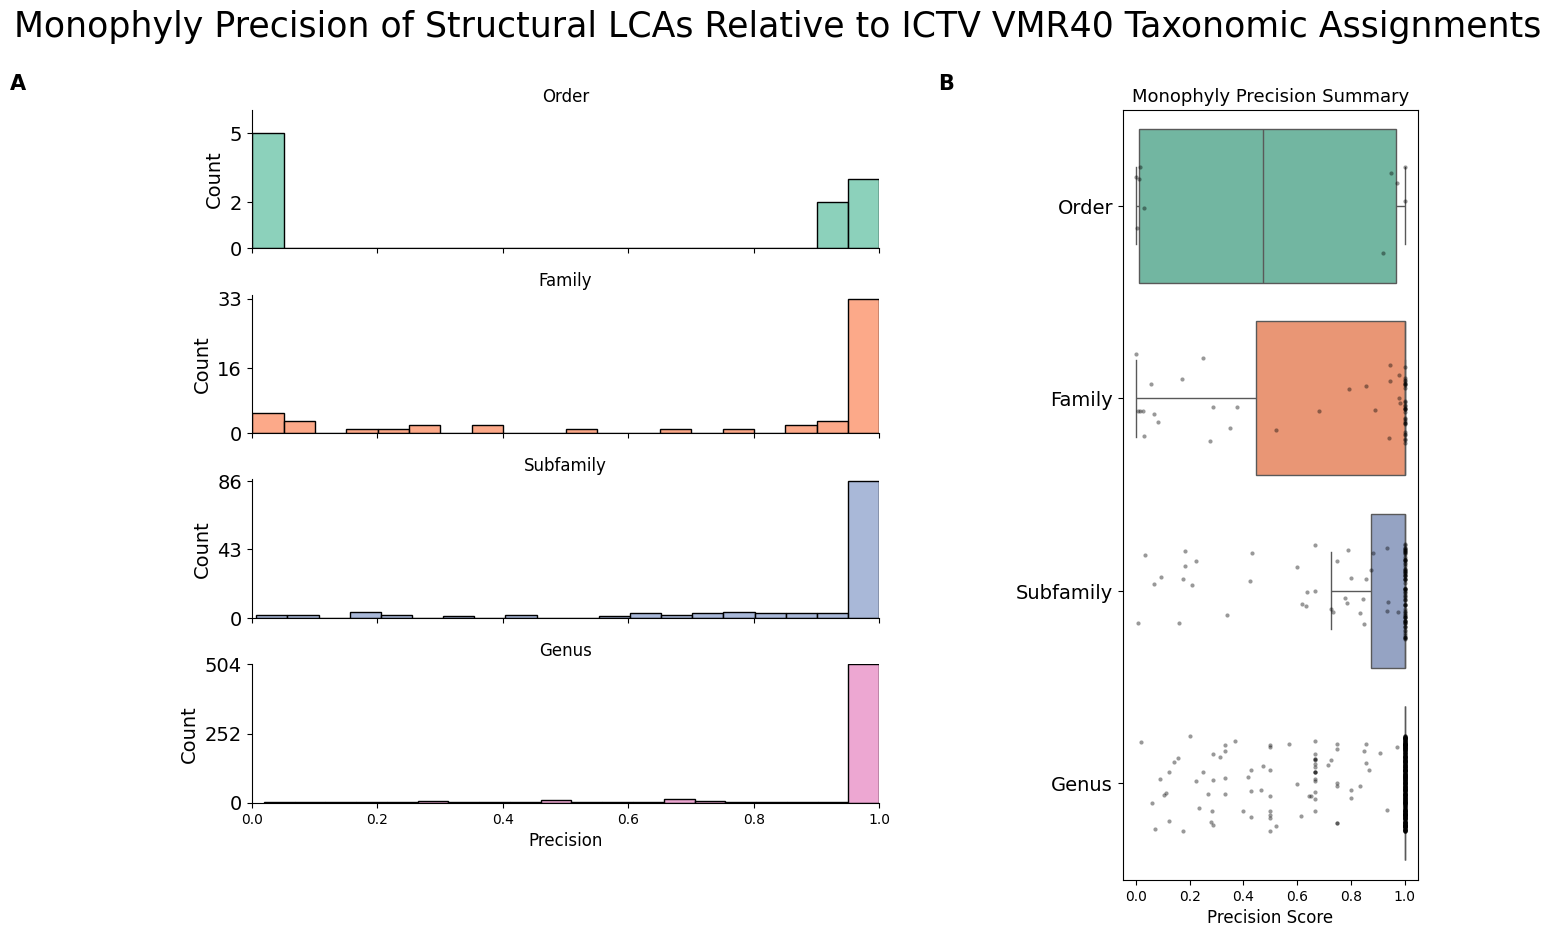

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.gridspec as gridspec

# Define rank order and palette
rank_order = ["Order", "Family", "Subfamily", "Genus"]
palette = sns.color_palette("Set2", n_colors=len(rank_order))
rank_colors = dict(zip(rank_order, palette))
precision_all["Rank"] = pd.Categorical(precision_all["Rank"], categories=rank_order, ordered=True)

# Set up figure
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1], wspace=0.4)

# Create outer axis (just to hold the histograms)
outer_ax = plt.subplot(gs[0])
outer_ax.axis("off")  # hide unwanted border

# Plot histograms for each rank
n_ranks = len(rank_order)
height_per_plot = 0.18
spacing = 0.06

# Step 1: get global max count across all rank histograms
from numpy import histogram

max_y = 0
for rank in rank_order:
    data = precision_all[precision_all["Rank"] == rank]["Precision"]
    counts, _ = histogram(data, bins=20)
    max_y = max(max_y, counts.max())

for i, rank in enumerate(rank_order):
    y_pos = 1 - (i * (height_per_plot + spacing)) - height_per_plot
    ax = outer_ax.inset_axes([0.1, y_pos, 0.85, height_per_plot])
    
    sns.histplot(
        data=precision_all[precision_all["Rank"] == rank],
        x="Precision",
        bins=20,
        color=rank_colors[rank],
        edgecolor="black",
        ax=ax
    )

    ax.set_xlim(0, 1)
    # Set custom y-axis ticks: 0, mid, max
    counts, _ = np.histogram(
        precision_all[precision_all["Rank"] == rank]["Precision"],
        bins=20
    )
    max_count = counts.max()
    mid_count = max_count // 2

    ax.set_ylim(0, max_count + 1)
    ax.set_yticks([0, mid_count, max_count])
    ax.set_yticklabels([0, mid_count, max_count], fontsize=14)

    ax.set_title(rank, fontsize=12, loc="center")

    if i != n_ranks - 1:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Precision", fontsize=12)
    
    ax.set_ylabel("Count", fontsize=14)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

# for i, rank in enumerate(rank_order):
#     y_pos = 1 - (i * (height_per_plot + spacing)) - height_per_plot
#     ax = outer_ax.inset_axes([0.1, y_pos, 0.85, height_per_plot])
    
#     sns.histplot(
#         data=precision_all[precision_all["Rank"] == rank],
#         x="Precision",
#         bins=20,
#         color=rank_colors[rank],
#         edgecolor="black",
#         ax=ax
#     )
    
#     ax.set_xlim(0, 1)
#     ax.set_title(rank, fontsize=12, loc="center")

#     # Clean up axes
#     if i != n_ranks - 1:
#         ax.set_xticklabels([])
#         ax.set_xlabel("")
#     else:
#         ax.set_xlabel("Precision", fontsize=12)
    
#     if i != 0:
#         ax.set_yticklabels([])
#         ax.set_ylabel("")
#     else:
#         ax.set_ylabel("Count", fontsize=12)
    
#     for spine in ["top", "right"]:
#         ax.spines[spine].set_visible(False)

# Boxplot on the right
ax1 = plt.subplot(gs[1])
sns.boxplot(
    data=precision_all,
    y="Rank",
    x="Precision",
    hue="Rank",
    palette=rank_colors,
    fliersize=0,
    ax=ax1,
    dodge=False
)
sns.stripplot(
    data=precision_all,
    y="Rank",
    x="Precision",
    color="black",
    size=3,
    jitter=0.25,
    alpha=0.4,
    ax=ax1
)

ax1.set_title("Monophyly Precision Summary", fontsize=13)
ax1.set_xlabel("Precision Score", fontsize=12)
ax1.set_ylabel("")
ax1.tick_params(axis='y', labelsize=14)

# Final layout
fig.suptitle("Monophyly Precision of Structural LCAs Relative to ICTV VMR40 Taxonomic Assignments", fontsize=25, y=0.98)
plt.tight_layout()
# Add 'A' and 'B' labels to the subplots
fig.text(0.02, 0.9, "A", fontsize=15, fontweight='bold')  # Left panel
fig.text(0.6, 0.9, "B", fontsize=15, fontweight='bold')  # Right panel (adjust if needed)

#plt.savefig("../plots/combined_monophyly_precision_plot.png", dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\crtuser\AppData\Local\Temp\ipykernel_12844\1815667724.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


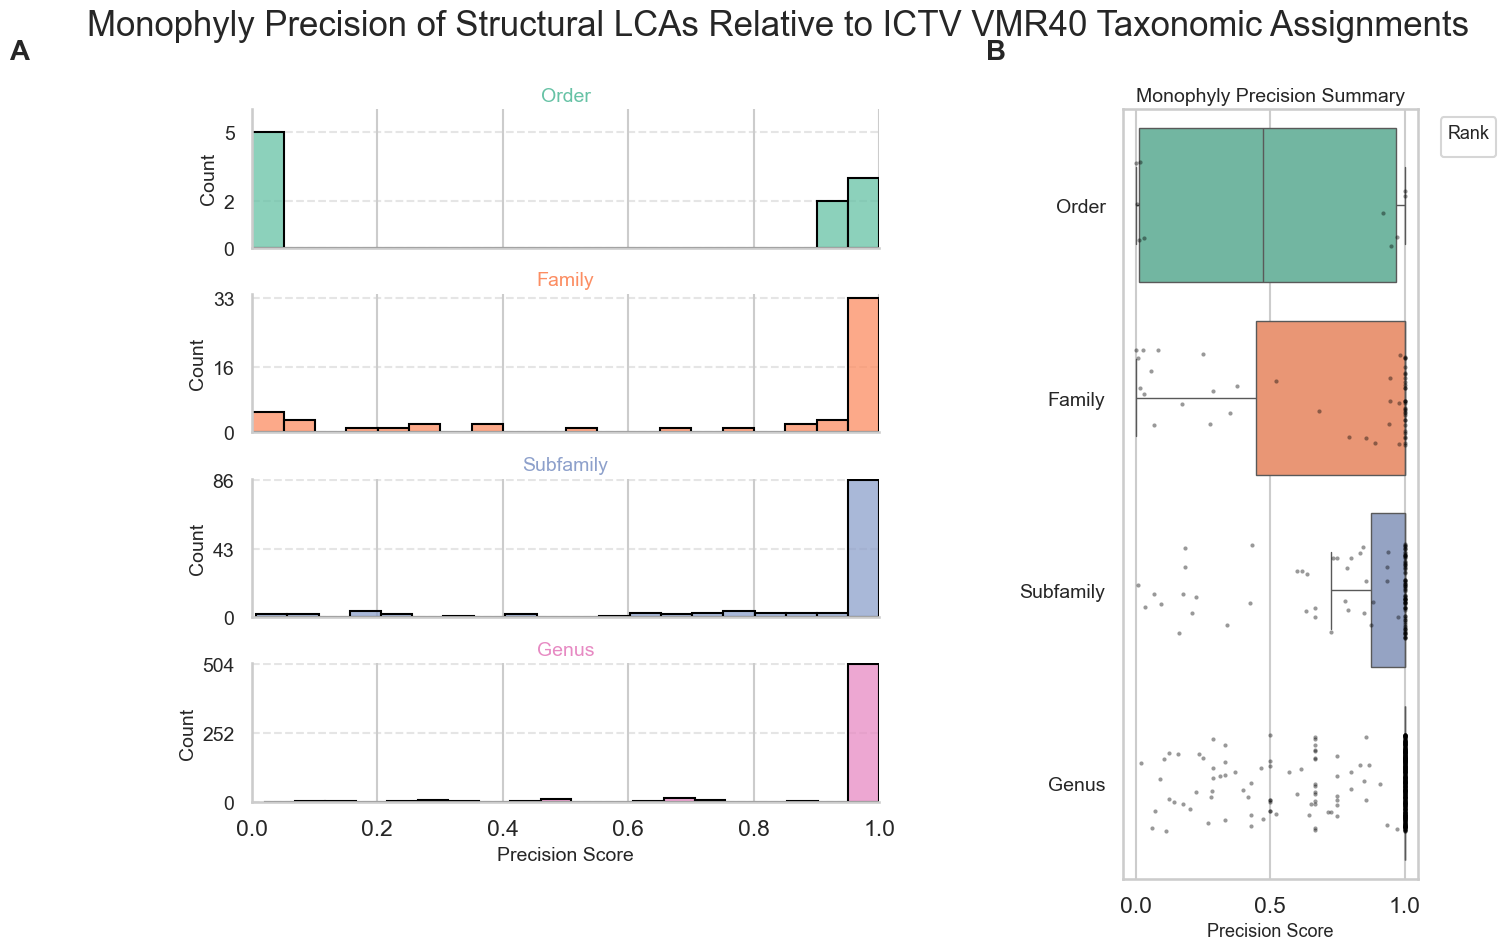

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec

# Global style settings
sns.set_theme(style="whitegrid", context="talk")

# Define rank order and palette
rank_order = ["Order", "Family", "Subfamily", "Genus"]
palette = sns.color_palette("Set2", n_colors=len(rank_order))
rank_colors = dict(zip(rank_order, palette))
precision_all["Rank"] = pd.Categorical(precision_all["Rank"], categories=rank_order, ordered=True)

# Set up figure and grid layout
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1], wspace=0.4)

# Create outer axis (for the histograms)
outer_ax = plt.subplot(gs[0])
outer_ax.axis("off")

# Histogram layout parameters
n_ranks = len(rank_order)
height_per_plot = 0.18
spacing = 0.06

# Step 1: get global max count across all rank histograms
max_y = 0
for rank in rank_order:
    data = precision_all[precision_all["Rank"] == rank]["Precision"]
    counts, _ = np.histogram(data, bins=20)
    max_y = max(max_y, counts.max())

# Plot histograms
for i, rank in enumerate(rank_order):
    y_pos = 1 - (i * (height_per_plot + spacing)) - height_per_plot
    ax = outer_ax.inset_axes([0.1, y_pos, 0.85, height_per_plot])
    
    sns.histplot(
        data=precision_all[precision_all["Rank"] == rank],
        x="Precision",
        bins=20,
        color=rank_colors[rank],
        edgecolor="black",
        ax=ax
    )

    # Consistent limits and ticks
    counts, _ = np.histogram(
        precision_all[precision_all["Rank"] == rank]["Precision"],
        bins=20
    )
    max_count = counts.max()
    mid_count = max_count // 2

    ax.set_xlim(0, 1)
    ax.set_ylim(0, max_count + 1)
    ax.set_yticks([0, mid_count, max_count])
    ax.set_yticklabels([0, mid_count, max_count], fontsize=14)

    # Style enhancements
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_title(rank, fontsize=14, loc="center", color=rank_colors[rank])
    ax.xaxis.labelpad = 5

    if i != n_ranks - 1:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Precision Score", fontsize=14)
    
    ax.set_ylabel("Count", fontsize=14)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

# Boxplot on the right
ax1 = plt.subplot(gs[1])
sns.boxplot(
    data=precision_all,
    y="Rank",
    x="Precision",
    hue="Rank",
    palette=rank_colors,
    fliersize=0,
    ax=ax1,
    dodge=False
)
sns.stripplot(
    data=precision_all,
    y="Rank",
    x="Precision",
    color="black",
    size=3,
    jitter=0.25,
    alpha=0.4,
    ax=ax1
)

ax1.set_title("Monophyly Precision Summary", fontsize=14)
ax1.set_xlabel("Precision Score", fontsize=13)
ax1.set_ylabel("")
ax1.tick_params(axis='y', labelsize=14)
ax1.legend(title="Rank", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12, title_fontsize=13)

# Final layout adjustments
fig.suptitle("Monophyly Precision of Structural LCAs Relative to ICTV VMR40 Taxonomic Assignments", fontsize=25, y=0.98)
fig.text(0.02, 0.93, "A", fontsize=20, fontweight='bold')  # Left panel
fig.text(0.63, 0.93, "B", fontsize=20, fontweight='bold')  # Right panel

plt.tight_layout()
# plt.savefig("../plots/combined_monophyly_precision_plot.png", dpi=300, bbox_inches="tight")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\crtuser\AppData\Local\Temp\ipykernel_12844\833159580.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


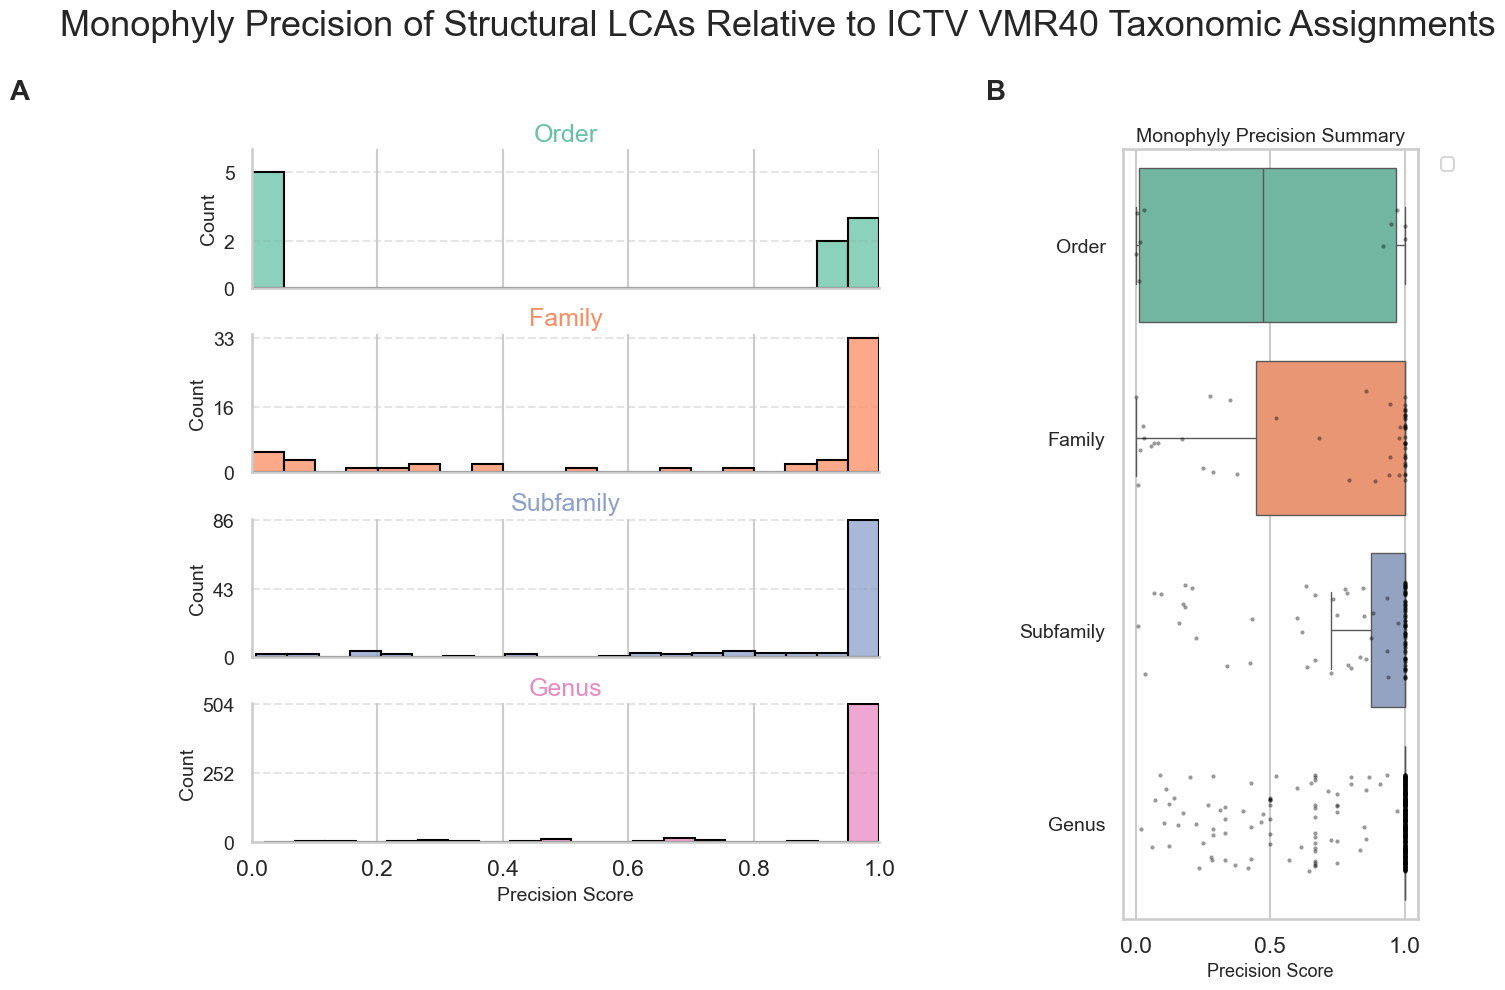

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec

# Global style settings
sns.set_theme(style="whitegrid", context="talk")

# Define rank order and palette
rank_order = ["Order", "Family", "Subfamily", "Genus"]
palette = sns.color_palette("Set2", n_colors=len(rank_order))
rank_colors = dict(zip(rank_order, palette))
precision_all["Rank"] = pd.Categorical(precision_all["Rank"], categories=rank_order, ordered=True)

# Set up figure and grid layout
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1], wspace=0.4)

# Create outer axis (for the histograms)
outer_ax = plt.subplot(gs[0])
outer_ax.axis("off")

# Histogram layout parameters
n_ranks = len(rank_order)
height_per_plot = 0.18
spacing = 0.06

# Step 1: get global max count across all rank histograms
max_y = 0
for rank in rank_order:
    data = precision_all[precision_all["Rank"] == rank]["Precision"]
    counts, _ = np.histogram(data, bins=20)
    max_y = max(max_y, counts.max())

# Plot histograms
for i, rank in enumerate(rank_order):
    y_pos = 1 - (i * (height_per_plot + spacing)) - height_per_plot
    ax = outer_ax.inset_axes([0.1, y_pos, 0.85, height_per_plot])
    
    sns.histplot(
        data=precision_all[precision_all["Rank"] == rank],
        x="Precision",
        bins=20,
        color=rank_colors[rank],
        edgecolor="black",
        ax=ax
    )

    # Consistent limits and ticks
    counts, _ = np.histogram(
        precision_all[precision_all["Rank"] == rank]["Precision"],
        bins=20
    )
    max_count = counts.max()
    mid_count = max_count // 2

    ax.set_xlim(0, 1)
    ax.set_ylim(0, max_count + 1)
    ax.set_yticks([0, mid_count, max_count])
    ax.set_yticklabels([0, mid_count, max_count], fontsize=14)

    # Style enhancements
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_title(rank, fontsize=18, loc="center", color=rank_colors[rank])  # ✅ Bigger titles
    ax.xaxis.labelpad = 5

    if i != n_ranks - 1:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Precision Score", fontsize=14)
    
    ax.set_ylabel("Count", fontsize=14)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

# Boxplot on the right
ax1 = plt.subplot(gs[1])
sns.boxplot(
    data=precision_all,
    y="Rank",
    x="Precision",
    hue="Rank",
    palette=rank_colors,
    fliersize=0,
    ax=ax1,
    dodge=False
)
sns.stripplot(
    data=precision_all,
    y="Rank",
    x="Precision",
    color="black",
    size=3,
    jitter=0.25,
    alpha=0.4,
    ax=ax1
)

ax1.set_title("Monophyly Precision Summary", fontsize=14)
ax1.set_xlabel("Precision Score", fontsize=13)
ax1.set_ylabel("")
ax1.tick_params(axis='y', labelsize=14)
ax1.legend(title=None, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12)  # ✅ No title

# Final layout adjustments
fig.suptitle("Monophyly Precision of Structural LCAs Relative to ICTV VMR40 Taxonomic Assignments", 
             fontsize=26, y=1.02)

fig.text(0.02, 0.93, "A", fontsize=20, fontweight='bold')  # Left panel
fig.text(0.63, 0.93, "B", fontsize=20, fontweight='bold')  # Right panel

# Tidy layout
try:
    plt.tight_layout(rect=[0, 0, 1, 0.97])
except:
    pass

# Save or show
plt.savefig("../data/plots/combined_monophyly_precision_plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [49]:
25/55

0.45454545454545453

In [70]:
ictv_metadata.Family.unique()

array([nan, 'Herelleviridae', 'Drexlerviridae', 'Casjensviridae',
       'Salasmaviridae', 'Straboviridae', 'Kyanoviridae',
       'Pervagoviridae', 'Forsetiviridae', 'Pachyviridae',
       'Aggregaviridae', 'Duneviridae', 'Helgolandviridae',
       'Molycolviridae', 'Assiduviridae', 'Winoviridae', 'Intestiviridae',
       'Suoliviridae', 'Steigviridae', 'Crevaviridae', 'Schitoviridae',
       'Aliceevansviridae', 'Stanwilliamsviridae', 'Chaseviridae',
       'Rountreeviridae', 'Pootjesviridae', 'Peduoviridae',
       'Kleczkowskaviridae', 'Guelinviridae', 'Grimontviridae',
       'Demerecviridae', 'Graaviviridae', 'Haloferuviridae',
       'Pyrstoviridae', 'Shortaselviridae', 'Anaerodiviridae',
       'Leisingerviridae', 'Druskaviridae', 'Hafunaviridae',
       'Halomagnusviridae', 'Soleiviridae', 'Ackermannviridae',
       'Arenbergviridae', 'Autographiviridae', 'Chimalliviridae',
       'Fervensviridae', 'Fredfastierviridae', 'Madisaviridae',
       'Madridviridae', 'Mesyanzhinovvir

In [56]:
singleton_families = ictv_metadata[~ictv_metadata.Family.isin(family_precision_df.Family.to_list())]

In [80]:
singleton_families.groupby(['Family'])['genome_accn'].count().shape

(25,)

In [61]:
family_precision_df[family_precision_df.Precision==1].shape

(30, 5)

In [71]:
family_precision_df[family_precision_df.Precision<1]

,Family,Num Members,LCA Size,Monophyletic,Precision
32,Ackermannviridae,63,64,False,0.984
4,Straboviridae,208,212,False,0.981
2,Casjensviridae,50,51,False,0.980
18,Aliceevansviridae,126,133,False,0.947
53,Autosignataviridae,34,36,False,0.944
5,Kyanoviridae,66,70,False,0.943
51,Autotranscriptaviridae,146,164,False,0.890
9,Duneviridae,6,7,False,0.857
43,Vilmaviridae,27,34,False,0.794
52,Autoscriptoviridae,94,138,False,0.681


In [79]:
family_precision_df.sort_values(by=['Precision','Num Members'],ascending=False)\
                    .reset_index(drop=True).to_csv('../data/supplementary_family_structural_monophyl.csv',index=False)